In [159]:
import pandas as pd
import numpy as np
import math

# Create Pair Data by Concatenating Features

In [160]:
# This method takes in the image pair dataset(df_pair) along with the feature dataset(df). 
# It then joins df with df_pair on image_id_A and image_id_B thus creating a dataframe 
# with allthe features of image A and image B i.e. 18 features.
def create_pair_data_concat(df, df_pair):
    df.rename(columns={'img_id': 'img_id_A'}, inplace=True)
    df_new = pd.merge(df_pair, df, on="img_id_A")
    
    df.rename(columns={'img_id_A': 'img_id_B'}, inplace=True)
    df_new = pd.merge(df_new, df, on="img_id_B")
    df.rename(columns={'img_id_B': 'img_id'}, inplace=True)
    return df_new  

# Create Pair Data by Subtracting Features

In [161]:
# This method takes in the image pair dataset(df_final) along with the feature dataset(df). 
# It then joins df with df_final on image_id_A and image_id_B separately and performs 
# feature subtraction forming a dataframe consisting of 9 features.
def create_pair_data_subtract(df, df_final):
    df_target = df_final['target']
    df.rename(columns={'img_id': 'img_id_A'}, inplace=True)
    df1 = pd.merge(df_final, df, on="img_id_A")
    df1.drop(['img_id_A','img_id_B','target'], axis=1, inplace=True)
    df.rename(columns={'img_id_A': 'img_id_B'}, inplace=True)
    df2 = pd.merge(df_final, df, on="img_id_B")
    df.rename(columns={'img_id_B': 'img_id'}, inplace=True)
    df2.drop(['img_id_A','img_id_B','target' ], axis=1, inplace=True)
    df_sub = df1.sub(df2)
    df_final = np.absolute(df_sub)
    return df_final, df_target

# Generate Training, Validation data and target

In [162]:
def GenerateTestingData(df_final, TestingPercent = 10):
    T_len = int(math.ceil(len(df_final)*0.01*TestingPercent))
    print(T_len)
    df_testing = df_final[0:T_len]
    print(df_testing)
    df_training = df_final[T_len:len(df_final)]
    return df_testing, df_training

# This method accepts the entire training target data and splits it into the valPercent passed into it.
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    return t

# This method accepts the entire training data and splits it into the valPercent passed into it.
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    return d2

# This method accepts the entire validation data and splits it into the valPercent passed into it.
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    return dataMatrix

# This method accepts the entire validation target data and splits it into the valPercent passed into it.
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    return t


# Generate Raw Data

In [163]:
# This method takes in the feature data(df), the same pairs and different pairs to create the 
# feature concat and subtract dataset. For both operations, we select the same number of same 
# and different pair datasets and append the rows and randomize the dataset. We merge the 
# dataframes to concat/subtract the features and remove the columns where the feature 
# values accross the dataset iszero or variance is zero.
def generate_raw_data(df, df_diff, df_same, feature_operation, dataType):
    if feature_operation == "Concat":
        df_diff = df_diff.sample(n=df_same.shape[0])
        df_final = pd.concat([df_same, df_diff]).sample(frac=1).reset_index(drop=True)
        df_final = create_pair_data_concat(df, df_final)
        df_target = df_final['target']
        df_final.drop(['img_id_A','img_id_B','target' ], axis=1, inplace=True)
    if feature_operation == "Subtract":
        df_diff = df_diff.sample(n=df_same.shape[0])
        df_final = pd.concat([df_same, df_diff]).sample(frac=1).reset_index(drop=True)
        df_final, df_target = create_pair_data_subtract(df, df_final)
    uniques = df_final.apply(lambda x: x.nunique())
    df_final = df_final.drop(uniques[uniques==1].index, axis=1)
    return df_final, df_target   

## Model Definition

In [164]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop, SGD

import numpy as np

#input_size = 18
drop_out = 0.1
first_dense_layer_nodes  = 150
second_dense_layer_nodes = 120
final_layer_nodes = 2

# We define a model 
def get_model(input_size, dataType):
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
    
    model.add(Dense(final_layer_nodes))
    model.add(Activation('softmax'))
    model.summary()
    if dataType == "HOF":
        opt = SGD(lr=0.01)
        model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
    else:
        model.compile(optimizer='RMSprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model

# Train Model

In [165]:
%matplotlib inline

def train_model(model, processedData_training, processedLabel_training):
    history = model.fit(processedData_training
                    , processedLabel_training
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )
    df = pd.DataFrame(history.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))

# Calculate Accuracy

In [166]:
from sklearn.metrics import accuracy_score
def test_accuracy(model, processedData_testing):
    predictedTestLabel = model.predict(processedData_testing)
    predictedTestLabel = predictedTestLabel.argmax(axis=-1)
    testing_accuracy = accuracy_score(processedLabel_testing, predictedTestLabel)
    print("Testing Accuracy: " + str(testing_accuracy*100))

-----------------------HOF : Concat--------------------
159
[[1 0 1 ... 2 1 1]
 [2 2 1 ... 2 1 1]
 [2 1 0 ... 2 1 1]
 ...
 [3 0 1 ... 0 0 1]
 [2 1 1 ... 0 0 1]
 [2 1 1 ... 0 0 1]]
159
[1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1
 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0
 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0
 0 1 0 0 1 1 1 1 0 0 0]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 150)               2850      
_________________________________________________________________
activation_52 (Activation)   (None, 150)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 150)               0         
______________________________

/Users/atrayeenag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/atrayeenag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Train on 1138 samples, validate on 285 samples
Epoch 1/10000
1138/1138 [==============================] - 1s 986us/step - loss: 0.7191 - acc: 0.5105 - val_loss: 0.7085 - val_acc: 0.4982
Epoch 2/10000
1138/1138 [==============================] - 0s 96us/step - loss: 0.7041 - acc: 0.5237 - val_loss: 0.6897 - val_acc: 0.5404
Epoch 3/10000
1138/1138 [==============================] - 0s 97us/step - loss: 0.7132 - acc: 0.4938 - val_loss: 0.7086 - val_acc: 0.4877
Epoch 4/10000
1138/1138 [==============================] - 0s 97us/step - loss: 0.7092 - acc: 0.5132 - val_loss: 0.6877 - val_acc: 0.5263
Epoch 5/10000
1138/1138 [==============================] - 0s 95us/step - loss: 0.7029 - acc: 0.5299 - val_loss: 0.7003 - val_acc: 0.4982
Epoch 6/10000
1138/1138 [==============================] - 0s 97us/step - loss: 0.6981 - acc: 0.5220 - val_loss: 0.6855 - val_acc: 0.5474
Epoch 7/10000
1138/1138 [==============================] - 0s 100us/step - loss: 0.7073 - acc: 0.5264 - val_loss: 0.6859 - v

1138/1138 [==============================] - 0s 134us/step - loss: 0.6720 - acc: 0.5808 - val_loss: 0.6887 - val_acc: 0.5439
Epoch 60/10000
1138/1138 [==============================] - 0s 132us/step - loss: 0.6773 - acc: 0.5782 - val_loss: 0.6850 - val_acc: 0.5544
Epoch 61/10000
1138/1138 [==============================] - 0s 139us/step - loss: 0.6699 - acc: 0.5808 - val_loss: 0.6865 - val_acc: 0.5509
Epoch 62/10000
1138/1138 [==============================] - 0s 164us/step - loss: 0.6758 - acc: 0.5694 - val_loss: 0.6883 - val_acc: 0.5439
Epoch 63/10000
1138/1138 [==============================] - 0s 155us/step - loss: 0.6704 - acc: 0.6037 - val_loss: 0.6847 - val_acc: 0.5509
Epoch 64/10000
1138/1138 [==============================] - 0s 159us/step - loss: 0.6695 - acc: 0.5844 - val_loss: 0.6893 - val_acc: 0.5439
Epoch 65/10000
1138/1138 [==============================] - 0s 133us/step - loss: 0.6695 - acc: 0.5852 - val_loss: 0.6848 - val_acc: 0.5474
Epoch 66/10000
1138/1138 [=========

1138/1138 [==============================] - 0s 141us/step - loss: 0.6625 - acc: 0.6107 - val_loss: 0.6897 - val_acc: 0.5474
Epoch 118/10000
1138/1138 [==============================] - 0s 155us/step - loss: 0.6579 - acc: 0.6081 - val_loss: 0.6962 - val_acc: 0.5193
Epoch 119/10000
1138/1138 [==============================] - 0s 113us/step - loss: 0.6659 - acc: 0.5940 - val_loss: 0.6919 - val_acc: 0.5509
Epoch 120/10000
1138/1138 [==============================] - 0s 104us/step - loss: 0.6615 - acc: 0.6046 - val_loss: 0.6898 - val_acc: 0.5474
Epoch 121/10000
1138/1138 [==============================] - 0s 106us/step - loss: 0.6534 - acc: 0.6230 - val_loss: 0.6948 - val_acc: 0.5368
Epoch 122/10000
1138/1138 [==============================] - 0s 115us/step - loss: 0.6557 - acc: 0.6169 - val_loss: 0.6926 - val_acc: 0.5368
Epoch 123/10000
1138/1138 [==============================] - 0s 106us/step - loss: 0.6594 - acc: 0.6019 - val_loss: 0.6950 - val_acc: 0.5298
Epoch 124/10000
1138/1138 [==

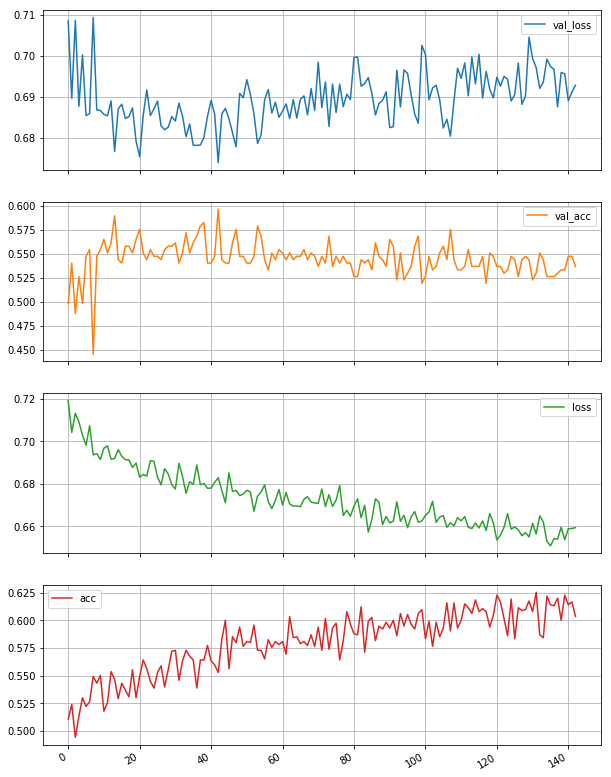

In [167]:
from keras.utils import np_utils

validation_data_split = 0.2
num_epochs = 10000  
model_batch_size = 100
tb_batch_size = 32
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

df_hof = pd.read_csv("HOF/HumanObserved-Features-Data.csv",index_col=0)
df_diff_hof = pd.read_csv("HOF/diffn_pairs.csv")
df_same_hof = pd.read_csv("HOF/same_pairs.csv")

df_gsc = pd.read_csv("GSC/GSC-Features.csv")
df_diff_gsc = pd.read_csv("GSC/diffn_pairs.csv")
df_same_gsc = pd.read_csv("GSC/same_pairs.csv")


print("-----------------------HOF : Concat--------------------")
df_final, df_target = generate_raw_data(df_hof, df_diff_hof, df_same_hof, "Concat","HOF")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1], "HOF")
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)

In [168]:
print("-----------------------HOF : Subtract--------------------")
df_final, df_target = generate_raw_data(df_hof, df_diff_hof, df_same_hof, "Subtract", "HOF")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1], "HOF")
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)

In [169]:
print("-----------------------GSC : Concat--------------------")
df_final, df_target = generate_raw_data(df_gsc, df_diff_gsc, df_same_gsc, "Concat", "GSC")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1], "GSC")
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)

In [170]:
print("-----------------------GSC : Subtract--------------------")
df_final, df_target = generate_raw_data(df_gsc, df_diff_gsc, df_same_gsc, "Subtract", "GSC")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1], "GSC")
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)